In [1]:
import mujoco
import mujoco_viewer
import matplotlib.pyplot as plt
import numpy as np

In [2]:
filepath = "model.xml"
model = mujoco.MjModel.from_xml_path(filepath)
data = mujoco.MjData(model)

In [3]:
AMP = [49.91, 49.62]
FREQ = [3.47, 3.66]
BIAS =[2.4, 28.9]

In [4]:
SIMEND = 20
TIMESTEP = 0.001
STEP_NUM = int(SIMEND / TIMESTEP)
timeseries = np.linspace(0, SIMEND, STEP_NUM)

AMP1 = np.deg2rad(AMP[0])
AMP2 = np.deg2rad(AMP[1])
q_d1 = AMP1 * np.sin(FREQ[0] * timeseries) + np.deg2rad(BIAS[0])
q_d2 = AMP2 * np.sin(FREQ[1] * timeseries) + np.deg2rad(BIAS[1])
dq_d1 = AMP1 * FREQ[0] *np.cos(FREQ[0] * timeseries)
dq_d2 = AMP2 * FREQ[1] * np.cos(FREQ[1] * timeseries)

carriage_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_SITE, "carriage")
q1_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_SENSOR, "q1")
q2_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_SENSOR, "q2")
q1_v_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_SENSOR, "dq1")
q2_v_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_SENSOR, "dq2")

first_joint_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_JOINT, "first_joint")
second_joint_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_JOINT, "second_joint")


In [5]:

KP = [255, 255]
KV = [0.4, 0.4]

def set_torque(mj_data, KP, KV, q_desired,dq_des):
    tendon1_pos = mj_data.qpos[first_joint_id]
    tendon2_pos = mj_data.qpos[second_joint_id]
    tendon1_vel = mj_data.sensordata[q1_v_id]
    tendon2_vel = mj_data.sensordata[q2_v_id]
    data.ctrl[0] = KP[0] * (q_desired[0] - tendon1_pos) + KV[0] * (dq_des[0] - tendon1_vel)
    data.ctrl[1] = KP[1] * (q_desired[1] - tendon2_pos) + KV[1] * (dq_des[1] - tendon2_vel)


In [6]:

Carriage_pos_x = []
Carriage_pos_z = []
q1_pos = []
q2_pos = []
simulation_times = []
completed_steps = 0
Carriage_pos_x = []
Carriage_pos_z = []
carriage_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_SITE, "carriage")
viewer = mujoco_viewer.MujocoViewer(model,
                                    data,
                                    title="Tendon",
                                    width=1920,
                                    height=1080)


for i in range(STEP_NUM):
    if viewer.is_alive:

        set_torque(data, KP, KV, [q_d1[i], q_d2[i]],[dq_d1[i],dq_d1[i]])

        Carriage_pos = data.site_xpos[carriage_id]
        Carriage_pos_x.append(Carriage_pos[0])
        Carriage_pos_z.append(Carriage_pos[2])
        # Сравним сенсоры и qpos
        current_q1 = data.qpos[first_joint_id]
        current_q2 = data.qpos[second_joint_id]

        q1_pos.append(current_q1)
        q2_pos.append(current_q2)

        simulation_times.append(data.time)
        mujoco.mj_step(model, data)
        viewer.render()
        completed_steps += 1
    else:
        break
viewer.close()

q_d1_completed = q_d1[:completed_steps]
q_d2_completed = q_d2[:completed_steps]

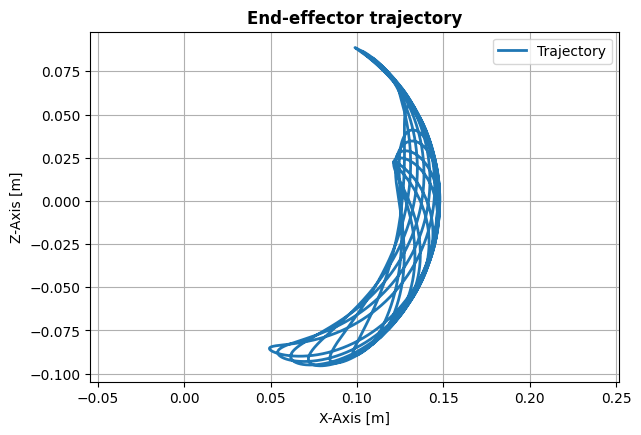

In [10]:
graph_start = int(STEP_NUM/20)
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(Carriage_pos_x[graph_start:STEP_NUM], Carriage_pos_z[graph_start:STEP_NUM], '-', linewidth=2, label='Trajectory')
plt.title('End-effector trajectory', fontsize=12, fontweight='bold')
plt.xlabel('X-Axis [m]')
plt.ylabel('Z-Axis [m]')
plt.axis('equal')
plt.grid()
plt.legend()